In [36]:
import pandas as pd
from pathlib import Path
import os


def main():
    df = (pd.read_csv("~/diabetic_data.csv")
        .rename(columns={"diag_1": "primary_diagnosis"}))
    # Create Outcome variables
    df.loc[:, "readmit_30_days"] = (df["readmitted"] == "<30")
    df.loc[:, "readmit_binary"] = (df["readmitted"] != "NO")
    # Replace missing values and re-code categories
    df.loc[:,"age"] = df.age.replace({"?": ""})
    df.loc[:,"payer_code"] = df["payer_code"].replace({"?", "Unknown"})
    df.loc[:,"medical_specialty"] = df["medical_specialty"].replace({"?": "Missing"})
    df.loc[:, "race"] = df["race"].replace({"?": "Unknown"})

    df.loc[:, "admission_source_id"] = df["admission_source_id"].replace({1: "Referral", 2: "Referral", 3: "Referral", 7: "Emergency"})
    df.loc[:, "age"] = df["age"].replace( ["[0-10)", "[10-20)", "[20-30)"], "30 years or younger")
    df.loc[:, "age"] = df["age"].replace(["[30-40)", "[40-50)", "[50-60)"], "30-60 years")
    df.loc[:, "age"] = df["age"].replace(["[60-70)", "[70-80)", "[80-90)"], "Over 60 years")
    
    
    
    # Clean various medical codes
    df.loc[:, "discharge_disposition_id"] = (df.discharge_disposition_id
                                            .apply(lambda x: "Discharged to Home" if x==1 else "Other"))

    df.loc[:, "admission_source_id"] = df["admission_source_id"].apply(lambda x: x if x in ["Emergency", "Referral"] else "Other")
    # Re-code Medical Specialties and Primary Diagnosis
    specialties = [
        "Missing",
        "InternalMedicine",
        "Emergency/Trauma",
        "Family/GeneralPractice",
        "Cardiology",
        "Surgery"
    ]
    df.loc[:, "medical_specialty"] = df["medical_specialty"].apply(lambda x: x if x in specialties else "Other")
    #
    df.loc[:, "primary_diagnosis"] = df["primary_diagnosis"].replace(
        regex={
            "[7][1-3][0-9]": "Musculoskeltal Issues",
            "250.*": "Diabetes",
            "[4][6-9][0-9]|[5][0-1][0-9]|786": "Respitory Issues",
            "[5][8-9][0-9]|[6][0-2][0-9]|788": "Genitourinary Issues"
        }
    )
    diagnoses = ["Respitory Issues", "Diabetes", "Genitourinary Issues", "Musculoskeltal Issues"]
    df.loc[:, "primary_diagnosis"] = df["primary_diagnosis"].apply(lambda x: x if x in diagnoses else "Other")

    
    #Binarize and bin features
    df.loc[:, "medicare"] = (df.payer_code == "MC")
    df.loc[:, "medicaid"] = (df.payer_code == "MD")

    df.loc[:, "had_emergency"] = (df["number_emergency"] > 0)
    df.loc[:, "had_inpatient_days"] = (df["number_inpatient"] > 0)
    df.loc[:, "had_outpatient_days"] = (df["number_outpatient"] > 0)

    # Save DataFrame
    cols_to_keep = ["race","gender","age","discharge_disposition_id","admission_source_id","admission_type_id","time_in_hospital",
        "medical_specialty","num_lab_procedures","num_procedures","num_medications","primary_diagnosis","number_diagnoses","max_glu_serum","A1Cresult","insulin","change",
        "diabetesMed", "medicare", "medicaid", "had_emergency", "had_inpatient_days", "had_outpatient_days", "readmitted","readmit_binary","readmit_30_days"]

    final_df = df.loc[:, cols_to_keep]
    final_df.to_csv( "~/diabetic_preprocessed.csv", index=False)

    print(df)
    

In [37]:
if __name__ == "__main__":
    main()

        encounter_id  patient_nbr             race  gender  \
0            2278392      8222157        Caucasian  Female   
1             149190     55629189        Caucasian  Female   
2              64410     86047875  AfricanAmerican  Female   
3             500364     82442376        Caucasian    Male   
4              16680     42519267        Caucasian    Male   
5              35754     82637451        Caucasian    Male   
6              55842     84259809        Caucasian    Male   
7              63768    114882984        Caucasian    Male   
8              12522     48330783        Caucasian  Female   
9              15738     63555939        Caucasian  Female   
10             28236     89869032  AfricanAmerican  Female   
11             36900     77391171  AfricanAmerican    Male   
12             40926     85504905        Caucasian  Female   
13             42570     77586282        Caucasian    Male   
14             62256     49726791  AfricanAmerican  Female   
15      

In [38]:
import numpy as np
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
 
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


from sklearn.preprocessing import StandardScaler 

# import various functions from sklearn 


from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

# import function to perform feature selection
from sklearn.feature_selection import RFE

In [39]:
diabet = pd.read_csv("~/diabetic_preprocessed.csv")
diabet.head()

,race,gender,age,discharge_disposition_id,admission_source_id,admission_type_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary,readmit_30_days
0,Caucasian,Female,30 years or younger,Other,Referral,6,1,Other,41,0,...,No,No,False,False,False,False,False,NO,False,False
1,Caucasian,Female,30 years or younger,Discharged to Home,Emergency,1,3,Missing,59,0,...,Ch,Yes,False,False,False,False,False,>30,True,False
2,AfricanAmerican,Female,30 years or younger,Discharged to Home,Emergency,1,2,Missing,11,5,...,No,Yes,False,False,False,True,True,NO,False,False
3,Caucasian,Male,30-60 years,Discharged to Home,Emergency,1,2,Missing,44,1,...,Ch,Yes,False,False,False,False,False,NO,False,False
4,Caucasian,Male,30-60 years,Discharged to Home,Emergency,1,1,Missing,51,0,...,Ch,Yes,False,False,False,False,False,NO,False,False


In [40]:
back = diabet

In [41]:
diabet = diabet.replace("?",np.nan)


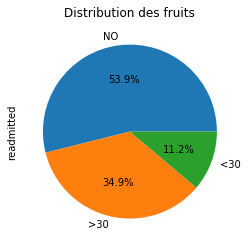

In [42]:
# Readmitted Days to inpatient readmission. Values: “<30” if the patient was readmitted in less than 30 days,
# “>30” if the patient was readmitted in more than 30 days, and “No” for no record of readmission

diabet['readmitted'].value_counts()/len(diabet)
counts = diabet['readmitted'].value_counts()

percentages = counts * 100 / len(diabet)

# créer un graphique de barres
fig, ax = plt.subplots()
percentages.plot(kind='pie', ax=ax, autopct='%1.1f%%')

# ajouter des étiquettes
ax.set_title('Distribution des fruits')

# afficher le graphique
plt.show()

## Data Cleaning and Feature Engineering

In [43]:
print(diabet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 26 columns):
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null object
discharge_disposition_id    101766 non-null object
admission_source_id         101766 non-null object
admission_type_id           101766 non-null int64
time_in_hospital            101766 non-null int64
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
primary_diagnosis           101766 non-null object
number_diagnoses            101766 non-null int64
max_glu_serum               101766 non-null object
A1Cresult                   101766 non-null object
insulin                     101766 non-null object
change                      101766 non-null object
diabetesMed                 

In [45]:
diabet.drop(['glyburide-metformin','glipizide-metformin','metformin-rosiglitazone' , 'metformin-pioglitazone', 'tolazamide','A1Cresult', 'metformin','repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride','acetohexamide', 'glipizide', 'glyburide', 'tolbutamide','pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone','glimepiride-pioglitazone','patient_nbr'], axis = 1, inplace = True)

In [46]:
diabet.describe()

,admission_type_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses
count,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,2.024006,4.395987,43.095641,1.339730,16.021844,7.422607
std,1.445403,2.985108,19.674362,1.705807,8.127566,1.933600
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,1.000000,2.000000,31.000000,0.000000,10.000000,6.000000
50%,1.000000,4.000000,44.000000,1.000000,15.000000,8.000000
75%,3.000000,6.000000,57.000000,2.000000,20.000000,9.000000
max,8.000000,14.000000,132.000000,6.000000,81.000000,16.000000


### Cleaning the Null Values

In [47]:
diabet.replace({'?': np.NAN},inplace=True)


In [48]:
diabet.columns

Index(['race', 'gender', 'age', 'discharge_disposition_id',
       'admission_source_id', 'admission_type_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'primary_diagnosis', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed',
       'medicare', 'medicaid', 'had_emergency', 'had_inpatient_days',
       'had_outpatient_days', 'readmitted', 'readmit_binary',
       'readmit_30_days'],
      dtype='object')

In [51]:
#not useful columns
diabet.drop(['weight','medical_specialty','payer_code','diag_1','diag_2','diag_3','encounter_id',
            'examide','citoglipton'],axis=1,inplace=True)

In [52]:
#column "readmitted" is the most important column since it shows if the patient got into problem again or not
diabet.readmitted.unique()


array(['NO', '>30', '<30'], dtype=object)

In [53]:
diabet.readmitted.value_counts()


NO     54864
>30    35545
<30    11357
Name: readmitted, dtype: int64

In [54]:
#converting the values of this column to numerical value
# if patient is back to hospital = 1
# if patient is not back to hospital = 1

diabet['readmitted'] = diabet['readmitted'].replace({'>30':1,'<30':1,'NO':0})


In [55]:
#this help to know which columns has higher correlation with the column of "readmitted"

diabet.corr()['readmitted']


admission_type_id     -0.004923
time_in_hospital       0.051289
num_lab_procedures     0.039253
num_procedures        -0.044748
num_medications        0.046772
number_diagnoses       0.112564
medicare               0.035598
medicaid               0.005080
had_emergency          0.124014
had_inpatient_days     0.214417
had_outpatient_days    0.110199
readmitted             1.000000
readmit_binary         1.000000
readmit_30_days        0.383331
Name: readmitted, dtype: float64

In [56]:
df = diabet.copy(deep=True)
df = df.groupby(['patient_nbr', 'readmitted']).transform('count')
df

In [57]:
diabet

,race,gender,age,discharge_disposition_id,admission_source_id,admission_type_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,...,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary,readmit_30_days
0,Caucasian,Female,30 years or younger,Other,Referral,6,1,Other,41,0,...,No,No,False,False,False,False,False,0,False,False
1,Caucasian,Female,30 years or younger,Discharged to Home,Emergency,1,3,Missing,59,0,...,Ch,Yes,False,False,False,False,False,1,True,False
2,AfricanAmerican,Female,30 years or younger,Discharged to Home,Emergency,1,2,Missing,11,5,...,No,Yes,False,False,False,True,True,0,False,False
3,Caucasian,Male,30-60 years,Discharged to Home,Emergency,1,2,Missing,44,1,...,Ch,Yes,False,False,False,False,False,0,False,False
4,Caucasian,Male,30-60 years,Discharged to Home,Emergency,1,1,Missing,51,0,...,Ch,Yes,False,False,False,False,False,0,False,False
5,Caucasian,Male,30-60 years,Discharged to Home,Referral,2,3,Missing,31,6,...,No,Yes,False,False,False,False,False,1,True,False
6,Caucasian,Male,Over 60 years,Discharged to Home,Referral,3,4,Missing,70,1,...,Ch,Yes,False,False,False,False,False,0,False,False
7,Caucasian,Male,Over 60 years,Discharged to Home,Emergency,1,5,Missing,73,0,...,No,Yes,False,False,False,False,False,1,True,False
8,Caucasian,Female,Over 60 years,Discharged to Home,Other,2,13,Missing,68,2,...,Ch,Yes,False,False,False,False,False,0,False,False
9,Caucasian,Female,[90-100),Other,Other,3,12,InternalMedicine,33,3,...,Ch,Yes,False,False,False,False,False,0,False,False


### distribution of the "admission type"

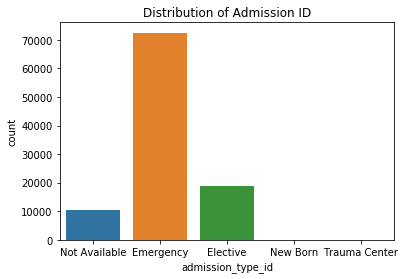

In [58]:
admission_type_id = {1.0:"Emergency", 2.0:"Emergency", 3.0:"Elective", 4.0:"New Born",
          5.0:"Not Available", 6.0:"Not Available", 7.0:"Trauma Center", 8.0:"Not Available"}

diabet.admission_type_id = diabet.admission_type_id.replace(admission_type_id)

sns.countplot(x = "admission_type_id", data = diabet)
plt.title("Distribution of Admission ID")
plt.show()

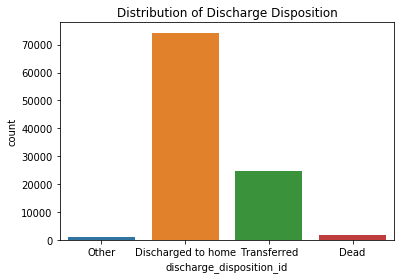

In [151]:
# discharge reason mapping
discharge_disposition_id={1 : 'Discharged to home', 2 : 'Transferred', 3 : 'Transferred',4 : 'Transferred',
                          5 : 'Transferred', 6 : 'Discharged to home', 7 : 'Discharged to home', 8 : 'Discharged to home',
                          9 : 'Transferred', 10 : 'Transferred', 11 : 'Dead', 12 : 'Transferred',13 : 'Discharged to home',
                          14 : 'Transferred', 15 : 'Transferred', 16 : 'Transferred', 17 : 'Transferred',18 : 'Transferred',
                          19 : 'Dead', 20 : 'Dead', 21 : 'Dead', 22 : 'Transferred', 23 : 'Transferred', 24 : 'Transferred',
                          25 : 'Other', 26 : 'Transferred', 30 : 'Transferred', 27 : 'Transferred', 28 : 'Transferred',
                          29 : 'Transferred'}

diabet.discharge_disposition_id = diabet.discharge_disposition_id.replace(discharge_disposition_id)

sns.countplot(x = "discharge_disposition_id", data = diabet)
plt.title("Distribution of Discharge Disposition")
plt.show()

In [152]:
diabet['race'].unique()

array(['Caucasian', 'AfricanAmerican', nan, 'Other', 'Asian', 'Hispanic'],
      dtype=object)

In [60]:
diabet['age'] = diabet['age'].replace({'[70-80)': 75, '[60-70)': 65, '[50-60)': 55, '[80-90)': 85, '[40-50)': 45, '[30-40)': 35, '[90-100)': 95, '[20-30)': 25, '[10-20)': 15, '[0-10)': 5})
diabet['gender'] = diabet['gender'].replace({'Female': 1, 'Male': 2, 'Unknown/Invalid':1})
diabet['race'] = diabet['race'].replace({'Caucasian': 1, 'AfricanAmerican': 2,'Asian': 3,'Hispanic': 4,'Other': 5, np.NaN:5})


In [157]:
# Change of medications Indicates if there was a change in diabetic medications (either dosage or generic name). Values: “change” and “no change”
# Diabetes medications Indicates if there was any diabetic medication prescribed. Values: “yes” and “no”

diabet['change'] = diabet['change'].replace("No", 0).replace("Ch", 1)
diabet['diabetesMed'] = diabet['diabetesMed'].replace("No", 0).replace("Yes", 1)

In [158]:
diabet['max_glu_serum'] = diabet['max_glu_serum'].replace(">200", 1).replace(">300", 1).replace("None", 0).replace("Norm", 2)


In [159]:
diabet['insulin'] = diabet['insulin'].replace({'No':0, 'Up':3, 'Steady':2, 'Down':1})

In [166]:
diabet['discharge_disposition_id'] = diabet['discharge_disposition_id'].replace({'Other':3, 'Discharged to home':2, 'Transferred':1, 'Dead':0})
diabet['admission_type_id'] = diabet['admission_type_id'].replace({'Not Available':0, 'Emergency':1, 'Elective':2, 'New Born':3, 'Trauma Center':1})
       



In [61]:
diabet.columns

Index(['race', 'gender', 'age', 'discharge_disposition_id',
       'admission_source_id', 'admission_type_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'primary_diagnosis', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'insulin', 'change', 'diabetesMed',
       'medicare', 'medicaid', 'had_emergency', 'had_inpatient_days',
       'had_outpatient_days', 'readmitted', 'readmit_binary',
       'readmit_30_days'],
      dtype='object')

In [184]:
diabet['readmitted'].value_counts()

0    54864
1    46902
Name: readmitted, dtype: int64

In [63]:
import pickle

with open('diabetes_df.pkl', 'wb') as f:
    pickle.dump(diabet, f)


# Classification

### Classification with Random Forest

In [182]:

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Select features and target variable
features = diabet.drop(columns=['readmitted'])

target = diabet['readmitted']

# Perform one-hot encoding on categorical features
features = pd.get_dummies(features)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize and train the random forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


# Calculate classification metrics
classification_metrics = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_metrics)

/Users/reihan/anaconda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.6013559988208705
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.73      0.66     10952
           1       0.59      0.46      0.51      9402

   micro avg       0.60      0.60      0.60     20354
   macro avg       0.60      0.59      0.59     20354
weighted avg       0.60      0.60      0.59     20354



### Classification with KNN (K nearest neighbors)

In [181]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and train the KNN classifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = knn_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate classification metrics
classification_metrics = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_metrics)

Accuracy: 0.5575808194949395
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.64      0.61     10952
           1       0.52      0.46      0.49      9402

   micro avg       0.56      0.56      0.56     20354
   macro avg       0.55      0.55      0.55     20354
weighted avg       0.55      0.56      0.55     20354



# Clustering

## Clustering with Kmeans

In [185]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Select features for clustering
features = diabet
#data[['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
                 #'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
                 #'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient',
                 #'number_diagnoses', 'max_glu_serum', 'insulin', 'change', 'diabetesMed']]

            
# Perform one-hot encoding on categorical features
features = pd.get_dummies(features)

# Standardize the numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Perform k-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)  # Specify the number of clusters
kmeans.fit(scaled_features)

# Get the cluster labels for each data point
cluster_labels = kmeans.labels_

# Add the cluster labels to the dataset
features['cluster'] = cluster_labels

# Print the number of samples in each cluster
print(features['cluster'].value_counts())

/Users/reihan/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/reihan/anaconda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


0    59461
1    42305
Name: cluster, dtype: int64


In [186]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
silhouette_avg = silhouette_score(scaled_features, cluster_labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.09513386419145084


In [190]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Select features for clustering
features = diabet
#data[['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id',
                 #'admission_source_id', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
                 #'num_medications', 'number_outpatient', 'number_emergency', 'number_inpatient',
                 #'number_diagnoses', 'max_glu_serum', 'insulin', 'change', 'diabetesMed']]
      
    
# Perform one-hot encoding on categorical features
features = pd.get_dummies(features)

# Standardize the numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Specify epsilon and min_samples
dbscan.fit(scaled_features)

# Get the cluster labels for each data point (-1 represents noise/outliers)
cluster_labels = dbscan.labels_

# Add the cluster labels to the dataset
features['cluster'] = cluster_labels

# Print the number of samples in each cluster (excluding outliers)
cluster_counts = features['cluster'].value_counts()
cluster_counts = cluster_counts[cluster_counts != -1]  # Exclude outliers
print(cluster_counts)

/Users/reihan/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/reihan/anaconda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


-1      100831
 0          35
 8          30
 11         29
 13         25
 22         25
 23         22
 43         21
 52         16
 59         16
 21         16
 62         15
 19         15
 60         15
 12         14
 56         13
 17         12
 36         12
 85         12
 81         12
 37         11
 82         11
 4          11
 61         10
 44         10
 25         10
 79         10
 94         10
 72          9
 18          9
         ...  
 69          5
 97          5
 89          5
 16          5
 98          5
 99          5
 100         5
 93          5
 29          5
 92          5
 38          5
 27          5
 90          5
 26          5
 28          5
 102         5
 88          5
 103         5
 86          5
 83          5
 45          5
 46          5
 110         5
 33          5
 7           4
 107         4
 95          4
 91          3
 108         3
 77          3
Name: cluster, Length: 114, dtype: int64


In [191]:

# Calculate the silhouette score
silhouette_avg = silhouette_score(scaled_features, cluster_labels)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: -0.42487192284216635
